# Exploration of Retinal Cells with AngioTool

### What do we want?

We want to know the effects of DEE mutations on blood vessel formation.

### How?

We want to determine if there are statistically significant differences in 

- Vessel density ("Vessels percentage area")
- Branch points ("Junctions density")
- Vessel length ("Total Vessels Length")
- Total number of end points

### Experimental setup
- Handful of litters with DEE/DEE, DEE/+, +/+
    - Variation between litters is a potential problem because we have a small sample size.
- Multiple (3-5) images per animal

### Statistics plan
Our goal is to run a [paired t-test](http://www.biostathandbook.com/pairedttest.html) (mathematically equivalent to "two-way ANOVA without replication"). It is more powerful than a two-sample t-test since it controls for variation between litters.

Note: After calculating differences for each pair, it's a one-sample t-test to see whether the mean difference is equal to zero. 


### Load data


In [36]:
import numpy as np
import pandas as pd

unblinded_file = '../data/UnblindedAngioToolData.csv'
df = pd.read_csv(unblinded_file)

#df
df.head() # Look at first five rows

,Vessels percentage area,Junctions density,Total Vessels Length,Total Number of End Points,Litter,AnimalID,Genotype
0,65.03,165.45,14.21,16,35,35-3,+/+
1,61.50,254.01,16.88,17,35,35-3,+/+
2,55.25,218.72,15.50,29,35,35-3,+/+
3,55.22,191.56,14.47,37,35,35-5,DEE/DEE
4,51.73,190.07,13.18,32,35,35-5,DEE/DEE


### Average over Litter and Genotype

We have multiple images per litter/genotype, and a paired t-test requires one value for each combination. 


1. Pivot by `Genotype` and `Litter` using `set_index()`.

2. Make sure the genotype ordering is consistent for all litters by using `sort_index()`.

3. Calculate mean values within litters for each genotype

In [2]:
data_mean = (df
             .set_index(['Litter', 'Genotype']) # pivot
             .sort_index(level = ['Litter', 'Genotype'])
             .mean(level = ['Litter', 'Genotype'])
            )
data_mean

Vessels percentage area  Junctions density  \
Litter Genotype                                               
35     +/+                     60.593000         212.725000   
       DEE/DEE                 53.619000         185.499667   
36     +/+                     64.298667         237.625667   
       DEE/DEE                 62.152500         190.815667   
37     +/+                     58.682000         152.771333   
       DEE/+                   61.730500         224.650000   
       DEE/DEE                 54.292000         137.069667   
39     +/+                     56.754800         226.433200   
       DEE/+                   55.086333         166.699667   
       DEE/DEE                 50.380200         165.405000   
40     +/+                     55.955667         245.781667   
       DEE/+                   51.474500         154.939000   
       DEE/DEE                 51.083200         161.893600   
41     +/+                     49.744400         150.792200   
       DEE/DEE                 49.865333         128.593667   

                 Total Vessels Length  Total Number of End Points  
Litter Genotype                                                    
35     +/+                  15.531000                   20.666667  
       DEE/DEE              13.567333                   38.666667  
36     +/+                  16.085667                   26.333333  
       DEE/DEE              14.415500                   31.166667  
37     +/+                  13.102333                   25.333333  
       DEE/+                15.673000                   32.500000  
       DEE/DEE              12.666333                   27.666667  
39     +/+                  15.476600                   52.200000  
       DEE/+                13.478500                   36.500000  
       DEE/DEE              12.999400                   45.800000  
40     +/+                  16.085333                   46.833333  
       DEE/+                12.847500                   32.250000  
       DEE/DEE              13.234000                   34.200000  
41     +/+                  11.683800                   39.800000  
       DEE/DEE              11.324000                   40.666667

### Split data

`data_mean` is a `MultiIndex` object instead of your usual `DataFrame`

In [3]:
data_mean.index

MultiIndex(levels=[[35, 36, 37, 39, 40, 41], ['+/+', 'DEE/+', 'DEE/DEE']],
           labels=[[0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5], [0, 2, 0, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 2]],
           names=['Litter', 'Genotype'])

We will use `panda`'s cross-section function, `DataFrame.xs`, to separate our data by genotype.

| Wild type | Mutant  |
|-----------|---------|
| +/+       | DEE/DEE |

In [4]:
wild =   data_mean.xs('+/+',     level = 'Genotype')
mutant = data_mean.xs('DEE/DEE', level = 'Genotype')

In [5]:
## Get parameter data arrays
wildVPA =           wild['Vessels percentage area'].values
wildJunctions =     wild['Junctions density'].values
wildVesselsLength = wild['Total Vessels Length'].values
wildNEndPoints =    wild['Total Number of End Points'].values

mutantVPA =           mutant['Vessels percentage area'].values
mutantJunctions =     mutant['Junctions density'].values
mutantVesselsLength = mutant['Total Vessels Length'].values
mutantNEndPoints =    mutant['Total Number of End Points'].values

## Paired dot plots

These plots show how the pairing was done

In [6]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

def pair_dot_plot(befores, afters, ylabel):
    
    # plotting the points
    plt.scatter(np.zeros(len(befores)), befores)
    plt.scatter(np.ones(len(afters)), afters)

    # plotting the lines
    for i in range(len(befores)):
        plt.plot( [0,1], [befores[i], afters[i]], c='k')

    plt.xticks([0,1], ['+/+', 'mutant'])
    plt.xlim([-0.5, 1.5])
    plt.ylabel(ylabel)

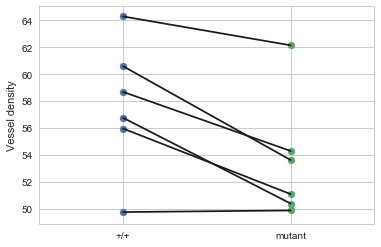

In [37]:
pair_dot_plot(wildVPA, mutantVPA, 'Vessel density')

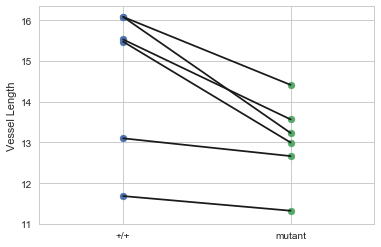

In [38]:
pair_dot_plot(wildVesselsLength, mutantVesselsLength, 'Vessel Length')

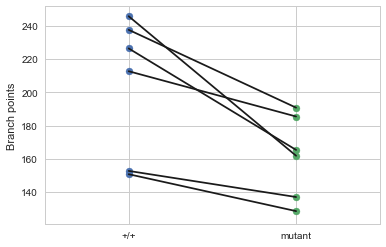

In [39]:
pair_dot_plot(wildJunctions, mutantJunctions, 'Branch points')

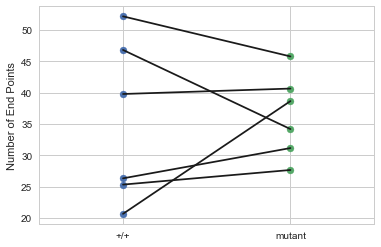

In [40]:
pair_dot_plot(wildNEndPoints, mutantNEndPoints, 'Number of End Points')

## Hypothesis testing

Now that we have our data ready to go, we can do a **paired t-test**.

`scipy` contains useful things for scientific analysis, and they have a built-in paired t-test function called `ttest_rel`.

In [11]:
from scipy import stats

## Do paired/dependent t-tests
t_VPA, p_VPA = stats.ttest_rel(wildVPA, mutantVPA)

t_junct, p_junct = stats.ttest_rel(wildJunctions, mutantJunctions)

t_vessel_length, p_vessel_length = stats.ttest_rel(wildVesselsLength, mutantVesselsLength)

t_n_endpoints, p_n_endpoints = stats.ttest_rel(wildNEndPoints, mutantNEndPoints)

t_statistics = [t_VPA, t_junct, t_vessel_length, t_n_endpoints]
p_values =     [p_VPA, p_junct, p_vessel_length, p_n_endpoints]

stat_df = pd.DataFrame({'Parameter': wild.columns,
                        't_statistic': t_statistics, 
                        'p_value': p_values})

stat_df.set_index('Parameter', inplace=True)
stat_df

,p_value,t_statistic
Parameter,,
Vessels percentage area,0.013137,3.761482
Junctions density,0.010334,3.998952
Total Vessels Length,0.012036,3.847175
Total Number of End Points,0.795419,-0.273483


## Effect size
The Cohen d$_z$ values indicate that our effect sizes are on the order of 1.5$\sigma$.

There's some concern that Cohen's d is biased upwards for small samples (n < 20)

It appears that our p-values for 
- `Vessels percentage area` 
- `Junctions density`
- `Total Vessels Length`

are statistically significant at the p < 0.05 level.

However, p-values by themselves aren't very useful. Sure, there's indication of a statistically significant result, but what sort of a difference does it make?

To answer this, we can look at **effect size**.

"Cohen's d" is frequently seen among literature, but there are a handful of techniques that are mistakenly attributed to be Cohen's d. For a good review, I recommend https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3840331/.

In this analysis, we will use Cohen's $d_z$, where the $z$ reminds us that we are looking at the difference of two samples ($x$ and $y$).



In [12]:
## Calculate Cohen's d using test statistic and n
## https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3840331/
def get_cohens_d_z(t_statistic, n):
    """Returns Cohen's d_z
    
    One way of calculating Cohen's d is by 
    taking the t-statistic and dividing it by
    the square root of the sample size.
    """
    d = [t / np.sqrt(n)
         for t in t_statistic]
    
    return d

n = len(wildVPA)
cohens_d_values = get_cohens_d_z(t_statistics, n)

pd.options.display.float_format = '{:,.3f}'.format

stat_df['cohen_dz'] = cohens_d_values
stat_df

,p_value,t_statistic,cohen_dz
Parameter,,,
Vessels percentage area,0.013,3.761,1.536
Junctions density,0.010,3.999,1.633
Total Vessels Length,0.012,3.847,1.571
Total Number of End Points,0.795,-0.273,-0.112


For fun, we can calculate cohen's $d$ using means and stds. We expect calculating the effect size from the t-statistic to yield identical results.

First, we need to look at the difference in means (wild - mutant)

In [32]:
pd.options.display.float_format = '{:,.2f}'.format

## Look at the difference in means
diff = wild - mutant
diff

,Vessels percentage area,Junctions density,Total Vessels Length,Total Number of End Points
Litter,,,,
35,6.97,27.23,1.96,-18.00
36,2.15,46.81,1.67,-4.83
37,4.39,15.70,0.44,-2.33
39,6.37,61.03,2.48,6.40
40,4.87,83.89,2.85,12.63
41,-0.12,22.20,0.36,-0.87


Averaging through the litters will yield the mean difference

In [34]:
means = diff.mean()
means_df = pd.DataFrame(means, columns=['mean difference']) 
means_df

,mean difference
Vessels percentage area,4.11
Junctions density,42.81
Total Vessels Length,1.63
Total Number of End Points,-1.17


Standard deviation of the mean differences

In [16]:
stds = diff.std()
stds

Vessels percentage area       2.67
Junctions density            26.22
Total Vessels Length          1.04
Total Number of End Points   10.45
dtype: float64

In [15]:
summary_df = pd.concat([stat_df, means_df], axis=1)
summary_df

,p_value,t_statistic,cohen_dz,mean difference
Parameter,,,,
Vessels percentage area,0.01,3.76,1.54,4.11
Junctions density,0.01,4.00,1.63,42.81
Total Vessels Length,0.01,3.85,1.57,1.63
Total Number of End Points,0.80,-0.27,-0.11,-1.17


In [17]:
means/stds

Vessels percentage area       1.54
Junctions density             1.63
Total Vessels Length          1.57
Total Number of End Points   -0.11
dtype: float64

In [18]:
#fig, axes = plt.subplot(2,2, figsize=(10,10))
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline


# Summary plots

The first row is appropriate for an independent t-test (not what we did, so it shouldn't be shown).


The second row shows the paired t-test and how the mean of the differences is not equal to zero.

In [41]:
#data_mean = data_mean.reset_index(0).reset_index()
#data_mean

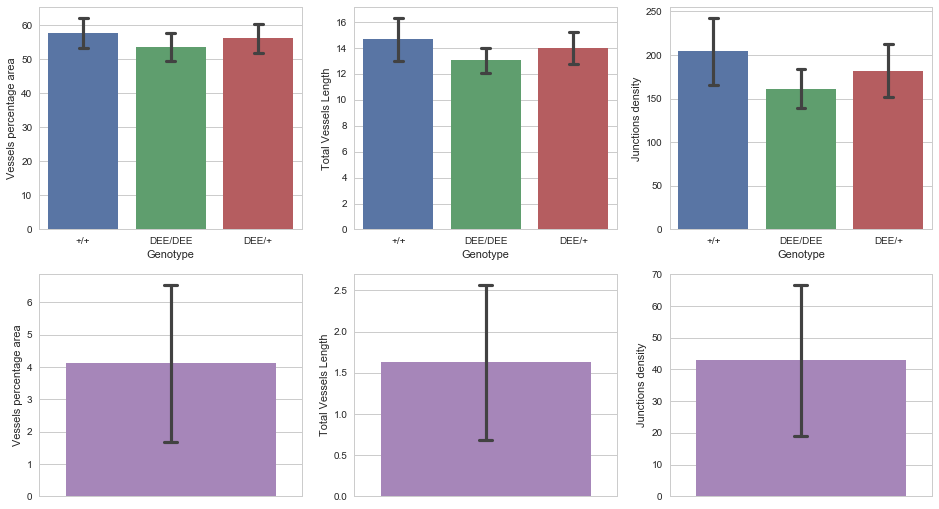

In [20]:
## This is what you would do for an independent t-test
## But we did a dependent t-test
## IMO this should not be shown since it is highly misleading

fig, axes = plt.subplots(nrows= 2, ncols=3, figsize = (16,9))
ax = axes.ravel()

parameters = ['Vessels percentage area', 'Total Vessels Length',
             'Junctions density']

with sns.plotting_context("notebook", font_scale=1.5):
    for i, parameter in enumerate(parameters): 
        g = sns.factorplot(x = 'Genotype',
                           y = parameter ,
                           #hue_order = ['+/+', 'DEE/DEE'],
                           ci = 'sd',
                           kind = 'bar',
                           capsize = .1,
                           data = data_mean,
                           ax = ax[i]
                          )
        
        _ = sns.barplot(diff[parameter],
                        ci = 'sd',
                        orient ='v',
                        capsize = .05,
                        ax = ax[i+3],
                        color = sns.xkcd_rgb["wisteria"],
                        #alpha=0.9
                       )
        ### factorplot creates its own figure
        ### But we can tell it to plot to a figure
        ### as created outside this loop.
        ### 
        ### If plt.close(g.fig) isn't called,
        ### there will be blank figures.
        plt.close(g.fig)


## Summary statistics 

If you want to look at the numbers after averaging over images, here they are.

### Number of end points

In [26]:
(df.groupby(['Litter', 'Genotype'])
                     ['Total Number of End Points']
                     .describe(percentiles=[])
)

count  mean   std   min   50%   max
Litter Genotype                                     
35     +/+        3.00 20.67  7.23 16.00 17.00 29.00
       DEE/DEE    3.00 38.67  7.64 32.00 37.00 47.00
36     +/+        3.00 26.33  3.51 23.00 26.00 30.00
       DEE/DEE    6.00 31.17  5.71 27.00 28.00 39.00
37     +/+        3.00 25.33  9.81 14.00 31.00 31.00
       DEE/+      2.00 32.50 12.02 24.00 32.50 41.00
       DEE/DEE    3.00 27.67  8.14 22.00 24.00 37.00
39     +/+        5.00 52.20  6.65 44.00 50.00 60.00
       DEE/+      6.00 36.50  9.22 26.00 33.50 53.00
       DEE/DEE    5.00 45.80  3.70 42.00 45.00 51.00
40     +/+        6.00 46.83  6.01 36.00 48.00 53.00
       DEE/+      4.00 32.25  6.08 25.00 32.50 39.00
       DEE/DEE    5.00 34.20  5.07 29.00 33.00 40.00
41     +/+        5.00 39.80  8.50 30.00 43.00 50.00
       DEE/DEE    3.00 40.67  6.81 33.00 43.00 46.00

### Vessel density

In [27]:
(df.groupby(['Litter', 'Genotype'])
                     ['Vessels percentage area']
                     .describe(percentiles=[])
)

count  mean  std   min   50%   max
Litter Genotype                                    
35     +/+        3.00 60.59 4.96 55.25 61.50 65.03
       DEE/DEE    3.00 53.62 1.76 51.73 53.91 55.22
36     +/+        3.00 64.30 2.31 62.81 63.13 66.96
       DEE/DEE    6.00 62.15 1.86 60.14 61.98 65.27
37     +/+        3.00 58.68 2.96 55.29 60.02 60.73
       DEE/+      2.00 61.73 5.38 57.92 61.73 65.54
       DEE/DEE    3.00 54.29 7.47 48.76 51.32 62.79
39     +/+        5.00 56.75 1.71 54.59 56.94 58.57
       DEE/+      6.00 55.09 2.05 52.11 54.79 58.11
       DEE/DEE    5.00 50.38 5.23 43.96 50.51 58.36
40     +/+        6.00 55.96 3.04 52.12 56.27 60.07
       DEE/+      4.00 51.47 3.82 46.53 52.22 54.94
       DEE/DEE    5.00 51.08 2.04 47.50 52.04 52.35
41     +/+        5.00 49.74 4.64 43.90 49.42 56.77
       DEE/DEE    3.00 49.87 1.52 48.60 49.45 51.55

### Branch points / Junctions density

In [28]:
(df.groupby(['Litter', 'Genotype'])
                     ['Junctions density']
                     .describe(percentiles=[])
)

count   mean   std    min    50%    max
Litter Genotype                                         
35     +/+        3.00 212.72 44.58 165.45 218.72 254.01
       DEE/DEE    3.00 185.50  9.24 174.87 190.07 191.56
36     +/+        3.00 237.63 40.63 198.62 234.56 279.70
       DEE/DEE    6.00 190.82 43.38 122.01 204.78 240.15
37     +/+        3.00 152.77 26.45 133.89 141.43 183.00
       DEE/+      2.00 224.65  2.96 222.56 224.65 226.74
       DEE/DEE    3.00 137.07 43.97 102.25 122.48 186.48
39     +/+        5.00 226.43 24.45 183.01 234.56 240.97
       DEE/+      6.00 166.70 16.34 148.98 165.42 194.03
       DEE/DEE    5.00 165.41 36.46 135.92 156.56 228.25
40     +/+        6.00 245.78 29.91 204.02 255.26 275.79
       DEE/+      4.00 154.94 20.85 140.56 146.92 185.35
       DEE/DEE    5.00 161.89 32.49 130.25 149.44 210.61
41     +/+        5.00 150.79 41.60  97.28 154.34 206.58
       DEE/DEE    3.00 128.59 34.62  88.94 144.03 152.81

### Vessel length

In [29]:
(df.groupby(['Litter', 'Genotype'])
                     ['Total Vessels Length']
                     .describe(percentiles=[])
)

count  mean  std   min   50%   max
Litter Genotype                                    
35     +/+        3.00 15.53 1.33 14.21 15.50 16.88
       DEE/DEE    3.00 13.57 0.78 13.05 13.18 14.47
36     +/+        3.00 16.09 1.44 14.64 16.09 17.52
       DEE/DEE    6.00 14.42 1.71 11.54 15.17 16.01
37     +/+        3.00 13.10 1.05 12.26 12.77 14.28
       DEE/+      2.00 15.67 0.02 15.66 15.67 15.69
       DEE/DEE    3.00 12.67 1.74 11.29 12.08 14.62
39     +/+        5.00 15.48 0.85 14.00 15.68 16.14
       DEE/+      6.00 13.48 0.90 12.36 13.52 15.02
       DEE/DEE    5.00 13.00 1.59 11.27 12.66 15.62
40     +/+        6.00 16.09 0.98 14.88 16.46 16.95
       DEE/+      4.00 12.85 1.03 11.96 12.61 14.21
       DEE/DEE    5.00 13.23 1.09 11.99 12.79 14.69
41     +/+        5.00 11.68 2.02  9.64 10.94 14.79
       DEE/DEE    3.00 11.32 1.96  9.08 12.18 12.71